## 전이학습 - 이미지세그멘테이션

In [4]:
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

# 가중치 불러오기
weights = DeepLabV3_ResNet50_Weights.DEFAULT
meta = weights.meta
print(meta.keys())
print(len(meta["categories"]))  # 학습된 클래스 레이블 목록


dict_keys(['categories', 'min_size', '_docs', 'num_params', 'recipe', '_metrics', '_ops', '_file_size'])
21


In [5]:
#-----------------------------------------------------------------------------
# DeepLabV3_ResNet50_Weights.DEFAULT 는 PASCAL VOC 2012 데이터셋으로 훈련
# VOC segmentation 클래스는 총 21개
# 20개 object class + 1개 background class
#-----------------------------------------------------------------------------
print(len(meta['categories']))
display(meta["categories"])

21


['__background__',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

(1336, 761)
torch.Size([1, 3, 520, 912])


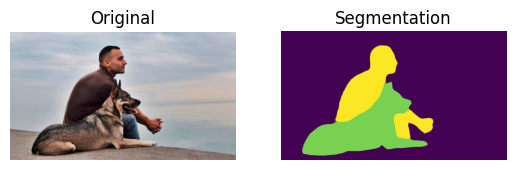

In [6]:
#---------------------------------------------------------
## 전이학습 모델중 세그멘테이션
#---------------------------------------------------------
import torch
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt



# 1. 모델 불러오기
# DeepLabV3-ResNet50 모델용 공식 사전학습 weight 세트 중에서 DEFAULT를 쓰고자함
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)
model.eval()

# 2. 전처리 파이프라인 (weights에 내장된 transform 사용 가능)
preprocess = weights.transforms()
file_img = r"D:\01.project\CodeIt\mission8\data\People_Image_Segmentation_Datasets\train\images\dog-ice-woman-purple.jpg"
file_img = r"D:\01.project\CodeIt\mission8\data\suup\test_seg.jpg"
# 3. 이미지 불러오기
img = Image.open(file_img)
# 2. 목표 크기 정의
target_size = (1336, 761)

# 3. 리사이즈 실행
# resize() 메서드의 인수는 (width, height) 형식의 튜플입니다.
img = img.resize(target_size)

print(img.size)  # (1336, 761)
x = preprocess(img).unsqueeze(0)  # torch.Size([1, 3, 520, 912])
print(x.shape)

# 4. 추론
with torch.no_grad():
    output = model(x)["out"][0]   # [num_classes, H, W]
pred = output.argmax(0)

# 5. 시각화
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred)
plt.title("Segmentation")
plt.axis("off")

plt.show()


In [ ]:
#------------------------------------------------------------------------------------------
# output[categories, h, w] =  카테고리 점수 (logit)
# output[0] → 백그라운드 클래스의 logit score map 로서 픽셀별 “그 클래스일 가능성을 나타내는 점수”입니다.
# output[1] → aeroplane(비행기)의 logit
#------------------------------------------------------------------------------------------
output.shape

In [ ]:
#---------------------------
# 0,0픽셀을 21개의 채널을 모두 다 확인했을때 가장 큰 값은 첫번째 값임
# 그래서 backgroun임
#---------------------------------------
for x in range(21):
  print(output[x][0,0])

In [ ]:
import numpy as np
np.set_printoptions(threshold=np.inf)

pred = np.argmax(output, axis=0)   # [H,W]
ys, xs = np.where(pred == 15)
print(ys[:3])  # ys[i] = i번째 15번 픽셀의 y좌표
print(xs[:3])   # , xs[i] = i번째 15번 픽셀의 x좌표

In [ ]:
#---------------------------------------
# 샘플: 사람 15번 검정색
# --------------------------------------
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 이미지 불러오기
img = cv2.imread(file_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 2. DeepLab 출력 크기(520,912)에 맞게 리사이즈
img = cv2.resize(img, (912, 520))   # (width, height)!!!

# 3. 복사본 생성
img_copy = img.copy()

# 4. pred == 15 좌표에 검정색 칠하기
for y, x in zip(ys, xs):
    img_copy[y, x] = [0, 0, 0]

# 5. 표시
plt.imshow(img_copy)
plt.axis("off")
plt.show()


In [ ]:
import torch.nn.functional as F
prob = F.softmax(output, dim=0)

plt.figure(figsize=(15,12))
for i in range(21):
    ax = plt.subplot(3,7,i+1)
    im = ax.imshow(prob[i].cpu().numpy(), cmap='viridis')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(i)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#################################
## 배경합성
################################
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

# 1. 세그멘테이션 모델 불러오기
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights).eval()
preprocess = weights.transforms()

# 2. 원본 & 배경 불러오기
img = cv2.imread(file_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
back_img_file = r"D:\01.project\CodeIt\mission8\data\People_Image_Segmentation_Datasets\train\images\youth-active-jump-happy-40815.jpg"
background = cv2.imread(back_img_file)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
background = cv2.resize(background, (img.shape[1], img.shape[0]))

# 3. 추론
pil_img = Image.fromarray(img)
input_tensor = preprocess(pil_img).unsqueeze(0)
with torch.no_grad():
    out = model(input_tensor)["out"][0]
pred = out.argmax(0).byte().cpu().numpy()
pred_resized = cv2.resize(pred, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

# 4. 사람(15) + 강아지(12) 마스크
mask = ((pred_resized == 15) | (pred_resized == 12)).astype(np.uint8)

# 5. 합성
mask_3ch = np.repeat(mask[:, :, None], 3, axis=2)
combined = img * mask_3ch + background * (1 - mask_3ch)

# 6. 시각화 (원본 / 세그멘테이션 / 배경 / 합성)
plt.figure(figsize=(20,6))

plt.subplot(1,4,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(pred_resized, cmap="tab20")  # 세그멘테이션 마스크
plt.title("Segmentation Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(background)
plt.title("Background")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(combined.astype(np.uint8))
plt.title("Combined Result")
plt.axis("off")

plt.show()
